# TP : Proximal coordinate descent method on regression models

#### Authors: R. Gower, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 16 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "oumayma"
ln1 = "bounou"
fn2 = "guillaume"
ln2 = "leveque"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_bounou_oumayma_and_leveque_guillaume.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

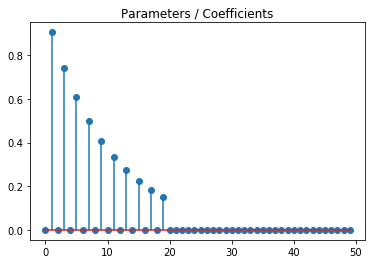

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}^n_+$, where $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return np.multiply(np.sign(x), np.maximum(0, (np.absolute(x) - s*t )))
    
    
def lasso(x, s):
    return s*np.linalg.norm(x, 1)
   

def indicator(x, s=0.):
    if np.any(x < 0) :
        return np.inf
    else:
        return 0
    
    
def prox_indicator(x, s, t=1.):
    return np.maximum(0,x)
    

- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

#### f is smooth and convex. In both cases, g is separable and each gi is convex. Thus we can apply proximal coordinate descent.

- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.

In [7]:
import random 

In [8]:
def cd_linreg(x0, A, b, g, prox_g, s, n_iter,
              x_true=coefs, verbose=False):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    
    r = b - A.dot(x) # residual

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    

    if verbose:
        print("Launching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(n_iter + 1):
        
        x_new = x.copy()
        i = random.randint(0, n_features - 1)
        L_i = A[:, i].T.dot(A[:, i])
        gamma_i = 1./L_i
        
        x_new[i] = prox_g(x[i] + gamma_i*A[:,i].T.dot(r), s, t=1.)
        r = r + A[:,i]*(x[i] - x_new[i]) # Residual update
        x = x_new

        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [9]:
# Some definitions before launching the algorithms
A, b = simu_linreg(coefs=coefs)
x0 = np.zeros(n_features)
s = 1e-2
n_iter = 1000

In [10]:
A

array([[-0.03, -0.26, -1.26, ...,  0.13, -0.66, -0.11],
       [ 0.17, -0.42,  0.42, ..., -0.53, -1.19, -0.6 ],
       [ 1.5 ,  1.51,  1.96, ...,  0.1 ,  1.05,  1.04],
       ..., 
       [-0.56, -1.7 ,  0.02, ...,  0.57, -0.17, -0.37],
       [ 1.46,  0.73, -0.22, ..., -1.56, -2.1 , -1.98],
       [-0.33, -0.65, -0.86, ...,  1.26, -0.47, -0.18]])


#### Let's first take a look at the distances to minimizee and minimum for both penalties

(0, 800)

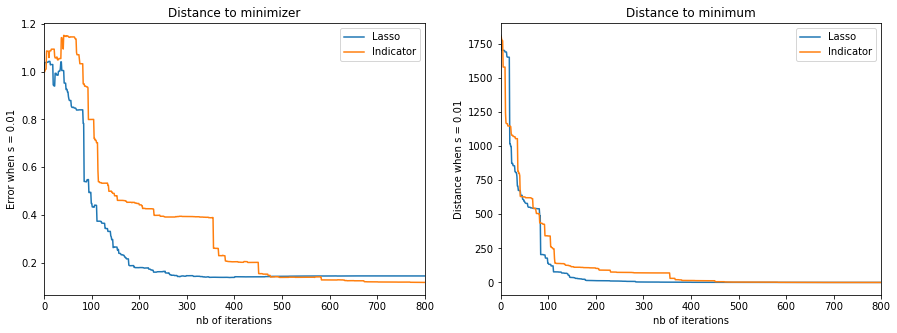

In [389]:
x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter)
x_ind, objectives_ind, errors_ind = cd_linreg(x0=x0, A=A, b=b, g=indicator, prox_g=prox_indicator, s=s, n_iter=n_iter)
minimum_ind = objectives_ind[-1]
minimum_lasso = objectives_lasso[-1]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot([x for x in range(n_iter+2)],[y for y in errors_lasso], label = 'Lasso')
plt.plot([x for x in range(n_iter+2)],[y for y in errors_ind], label = 'Indicator')
plt.xlabel('nb of iterations')
plt.ylabel('Error when s = {0}'.format(s))
plt.title('Distance to minimizer')
plt.xlim([0,800])
plt.legend()

plt.subplot(1,2,2)
plt.plot([x for x in range(n_iter+2)],[y for y in np.abs(objectives_lasso - minimum_lasso)], label = 'Lasso')
plt.plot([x for x in range(n_iter+2)],[y for y in np.abs(objectives_ind - minimum_ind)], label = 'Indicator')
plt.title('Distance to minimum')
plt.ylabel('Distance when s = {0}'.format(s))
plt.xlabel('nb of iterations')
plt.legend()
plt.xlim([0,800])

#### We notice that the problem with the indicator penalization converges faster than the same problem with the Lasso penalization.
#### Let's start modifying s

In [390]:
s_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

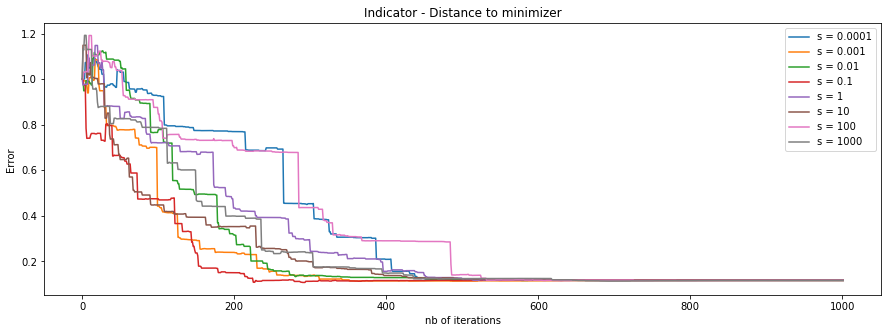

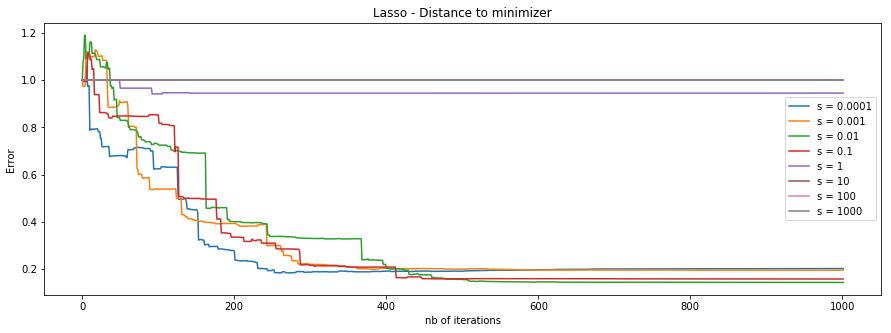

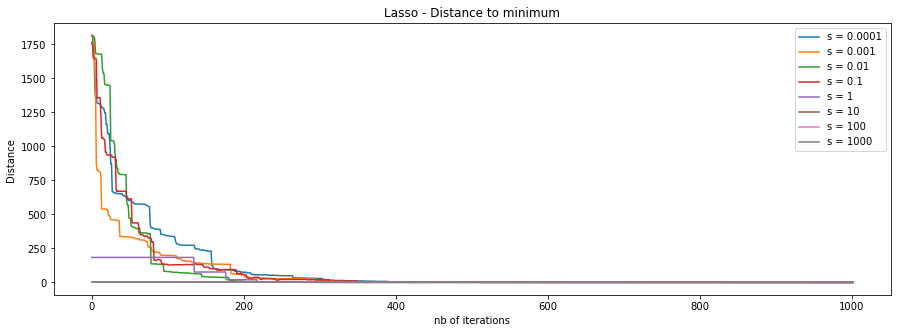

In [393]:
plt.figure(figsize=(15,5))
for s in s_list:
    #x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s)
    x_ind, objectives_ind, errors_ind = cd_linreg(x0=x0, A=A, b=b, g=indicator, prox_g=prox_indicator, s=s, n_iter=n_iter)
    minimum_ind = objectives_ind[-1]
    #minimum_lasso = objectives_lasso[-1]
    
    plt.plot([x for x in range(n_iter+2)],[y for y in errors_ind], label ='s = {0}'.format(s))
    plt.xlabel('nb of iterations')
    plt.ylabel('Error ')
    plt.title('Indicator - Distance to minimizer')
    #plt.xlim([0,800])
    plt.legend()
    
plt.figure(figsize=(15,5))
for s in s_list:
    x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter)
    #x_ind, objectives_ind, errors_ind = cd_linreg(x0=x0, A=A, b=b, g=indicator, prox_g=prox_indicator, s=s)
    #minimum_ind = objectives_ind[-1]
    minimum_lasso = objectives_lasso[-1]
    
    plt.plot([x for x in range(n_iter+2)],[y for y in errors_lasso], label ='s = {0}'.format(s))
    plt.xlabel('nb of iterations')
    plt.ylabel('Error ')
    plt.title('Lasso - Distance to minimizer')
    #plt.xlim([0,800])
    plt.legend()
    
plt.figure(figsize=(15,5))
for s in s_list:
    x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter)
    #x_ind, objectives_ind, errors_ind = cd_linreg(x0=x0, A=A, b=b, g=indicator, prox_g=prox_indicator, s=s)
    #minimum_ind = objectives_ind[-1]
    minimum_lasso = objectives_lasso[-1]
    
    plt.plot([x for x in range(n_iter+2)],[y for y in np.abs(objectives_lasso - minimum_lasso)], label ='s = {0}'.format(s))
    plt.xlabel('nb of iterations')
    plt.ylabel('Distance ')
    plt.title('Lasso - Distance to minimum')
    #plt.xlim([0,800])
    plt.legend()
    

#### We notice that the higher s, the faster the distance converges. 

- Bonus: Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

### Re-using the results from the first lab

In [305]:
def loss_linreg(x,A=A,b=b):
    """Least-squares loss"""
    # TODO
    #pass
    n = len(x)
    return (1./(2*n))*np.linalg.norm(np.dot(A,x)-b,2)**2


def grad_linreg(x,A=A,b=b):
    """Least-squares gradient"""
    n = len(x)
    return (1./n)*np.dot(A.T,np.dot(A,x)-b)


def lip_linreg(A=A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    #pass
    n=A.shape[1]
    return 1./n*np.linalg.norm(A.T.dot(A),2)


def ista(x0, f, grad_f, g, prox_g, step, A, b, s=0., n_iter=n_iter,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    obj_true = f(x_true) + g(x_true, s)

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        x = prox_g(x - step*grad_f(x,A,b), s, t=1.)
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors


def fista(x0, f, grad_f, g, prox_g, step, A,b, s=0., n_iter=n_iter,
         x_true=coefs, verbose=False):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    obj_true = f(x_true) + g(x_true, s)
    # An extra variable is required for FISTA
    z = x0.copy()
    beta=1
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Launching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        
        t_new = (1+np.sqrt(1+4*t**2))/2.
        x_new = prox_g(z - step*grad_f(z, A, b), s, t=1.)
        z_new = x_new + (t - 1)/t_new*(x_new - x)
        
        t = t_new
        x = x_new
        z = z_new
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

#### Let's change the conditioning parameter s on ISTA and FISTA, using the lasso penalization

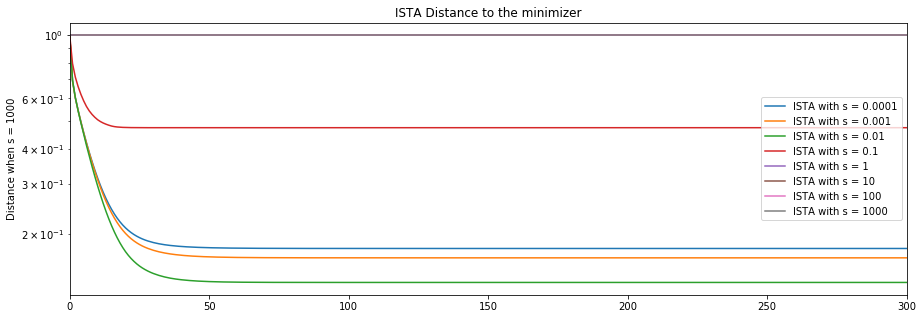

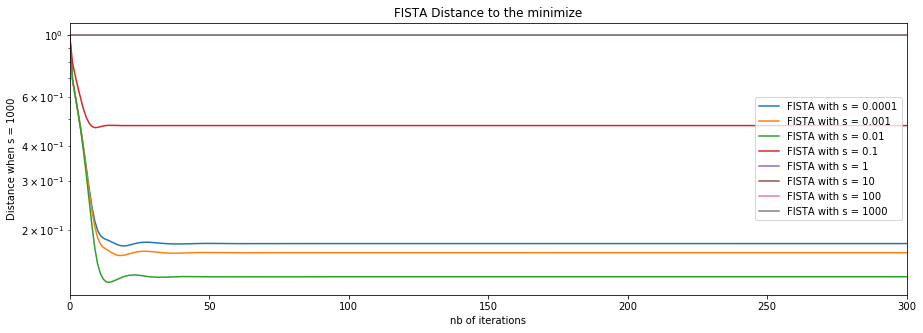

In [369]:
plt.figure(figsize=(15,5))
for s in s_list:
    x_ista, objectives_ista, errors_ista = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, A=A, b=b, 
                                                g=lasso, prox_g=prox_lasso, step=1./lip_linreg(A=A),
                                                s=s, x_true=coefs, verbose = False)
    minimum_ista = objectives_ista[-1]    
    plt.plot([x for x in range(n_iter + 2)],[y for y in errors_ista], label = 'ISTA with s = {0}'.format(s))
    #plt.plot([x for x in range(n_iter + 2)],[y for y in errors_fista], label = 'FISTA')
    plt.title("ISTA Distance to the minimizer")
    plt.xlim([0,300])
    plt.ylabel('Distance when s = {0}'.format(s))
    plt.legend()
    plt.yscale('log')

plt.figure(figsize=(15,5))
for s in s_list:    
    x_fista, objectives_fista, errors_fista = fista(x0=x0, f=loss_linreg, grad_f=grad_linreg, A=A, b=b, 
                                                g=lasso, prox_g=prox_lasso, step=1./lip_linreg(A=A),
                                                s=s, x_true=coefs, verbose = False)
    minimum_fista = objectives_fista[-1]
    plt.plot([x for x in range(n_iter + 2)],[y for y in errors_fista], label = 'FISTA with s = {0}'.format(s))
    plt.xlabel('nb of iterations')
    plt.title("FISTA Distance to the minimize")
    plt.xlim([0,300])
    plt.ylabel('Distance when s = {0}'.format(s))
    plt.legend()
    plt.yscale('log')

#### We notice that the gaps between the error plots for ISTA and FISTA are wider than the ones for the proximal coordinate descent. Also, we saw earlier that the rate of convergence in coordinate descent is not affected by bad conditionning, which is not the case for ISTA or FISTA. 